In [6]:
import sys
sys.path.append('C:/Users/s.velut/Documents/These/Protheus_PHD/Scripts')
from utils import get_BVEP_data, prepare_data, balance
from _utils import make_preds_accumul_aggresive
sys.path.append('C:/Users/s.velut/Documents/These/Protheus_PHD/Scripts/Wavelets/Jade/')
sys.path.insert(0,"C:\\Users\\s.velut\\Documents\\These\\moabb\\moabb\\datasets")
sys.path.insert(0,"C:\\Users\\s.velut\\Documents\\These\\moabb\\moabb\\paradigms")
import torch
import mne
import numpy as np
import time
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from pyriemann.estimation import XdawnCovariances, Xdawn
from SPDNet.torch.optimizers import riemannian_adam as torch_riemannian_adam
from matplotlib import pyplot as plt
from SPDNet.torch.spd_net_bn_torch import SPDNetBN_Torch, SPDNetBN_Module, CNNSPDNetBN_Module
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns


from research_code.pl_utils import get_jade
from castillos2023 import CasitllosCVEP100,CasitllosCVEP40,CasitllosBurstVEP100,CasitllosBurstVEP40


# mne.set_log_level('ERROR')

# MOABB implementation

In [ ]:
model = get_jade(n_freqs = 4,
        f_min = 1,
        f_max = 35,
        random_f_init = False,
        dtype = torch.float64,
        device=torch.device('cuda'),
        sfreq = 500,
        n_filter = 16,
        estimator= 'lwf',
        ini_n_filter=32*4,
        xdawn_estimator='lwf',
        channel_spd=1,
        temporal=False,
        n_classes = 2,
        bimap_dim = [64,32,16,8]   )
model
# model_pl = GreenClassifierLM(model=model,)
# model_pl

In [ ]:
np.random.uniform(5, 15, size=10).shape

In [ ]:
from moabb.evaluations import WithinSessionEvaluation, CrossSubjectEvaluation
from moabb.paradigms import CVEP
from sklearn.pipeline import make_pipeline
from braindecode import EEGClassifier
from braindecode.models import EEGNetv4
from sklearn.pipeline import make_pipeline
from skorch.callbacks import EarlyStopping, EpochScoring
from skorch.dataset import ValidSplit

from moabb.datasets import BNCI2014_001
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import MotorImagery
from moabb.utils import setup_seed
# Set random seed to be able to reproduce results
seed = 42
setup_seed(seed)

# Hyperparameter
LEARNING_RATE = 0.0625 * 0.01  # parameter taken from Braindecode
WEIGHT_DECAY = 0  # parameter taken from Braindecode
BATCH_SIZE = 64  # parameter taken from BrainDecode
EPOCH = 10
PATIENCE = 3
fmin = 4
fmax = 100
tmin = 0
tmax = None

# Define a Skorch classifier
clf = EEGClassifier(
    module=model,
    optimizer=torch_riemannian_adam.RiemannianAdam,
    optimizer__lr=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    max_epochs=EPOCH,
    train_split=ValidSplit(0.2, random_state=seed),
    device="cpu",
    callbacks=[
        EarlyStopping(monitor="valid_loss", patience=PATIENCE),
        EpochScoring(
            scoring="accuracy", on_train=True, name="train_acc", lower_is_better=False
        ),
        EpochScoring(
            scoring="accuracy", on_train=False, name="valid_acc", lower_is_better=False
        ),
    ],
    verbose=1,  # Not printing the results for each epoch
)



In [ ]:
# Create the pipelines
pipes = {}
pipes["Green"] = make_pipeline(clf)

paradigm = CVEP()
dataset = [CasitllosBurstVEP100()]


evaluation = WithinSessionEvaluation(
    paradigm=paradigm, datasets=dataset, suffix="examples", overwrite=False
)
results = evaluation.process(pipes)

In [ ]:
pl_crossval_output, _ = pl_crossval(
    model, 
    dataset=dataset,
    n_epochs=2,
    save_preds=True,
    ckpt_prefix='checkpoints/test',
    train_splits=[[0,1]],
    test_splits=[[2]],
    batch_size=64,
    pl_module=GreenClassifierLM,
    num_workers=0, 
)


# Own implementation

In [7]:
# get data

# subjects = [1,2,3]
subjects = [1,2,3,4,5,6,7,8,9,10,11,12]

nb_subject = len(subjects)
moabb_ds = CasitllosBurstVEP100()
on_frame = True
recenter = True
freq = 60 if on_frame else 500


raw_data,labels,codes,labels_codes = get_BVEP_data(subjects,on_frame,to_keep=None,moabb_ds=moabb_ds)
X_parent,Y_parent,domains_parent = prepare_data(subjects,raw_data,labels,on_frame,False,recenter,codes,normalise=True)

Choosing the first None classes from all possible events.


None
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
Using data from preloaded Raw for 60 events and 1101 original time points ...
0 bad epochs dropped
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
Using data from preloaded Raw for 60 events and 1101 original time points ...
0 bad epochs dropped
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
Using data from preloaded Raw for 60 events and 1101 original time points ...
0 bad epochs dropped
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
Using data from preloaded Raw for 60 events and 1101 original time points ...
0 bad epochs dropped
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
Using data from preloaded Raw for 60 events and 1101 original time points ...
0 bad epochs dropped
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
Using data from preloaded Raw for 60 events and 1101 original time points ...
0 bad ep

C:\Users\s.velut\Documents\These\moabb\moabb\datasets\castillos2023.py:129: RuntimeWarning: Data file name in EEG.data (P13_burst100.fdt) is incorrect, the file name must have changed on disk, using the correct file name (P6_burst100.fdt).
  raw = mne.io.read_raw_eeglab(file_path_list[0], preload=True, verbose=False)


C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
Using data from preloaded Raw for 60 events and 1101 original time points ...
0 bad epochs dropped
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
Using data from preloaded Raw for 60 events and 1101 original time points ...
0 bad epochs dropped
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
Using data from preloaded Raw for 60 events and 1101 original time points ...
0 bad epochs dropped
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
Using data from preloaded Raw for 60 events and 1101 original time points ...
0 bad epochs dropped
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
Using data from preloaded Raw for 60 events and 1101 original time points ...
0 bad epochs dropped
C:\Users\s.velut\mne_data\MNE-4class-vep-data\records\8255618\files\
Using data from preloaded Raw for 60 events and 1101 original time points ...
0 bad epochs 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'stim_trial', 'stim_epoch']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1651 samples (3.302 s)

7020 events found
Event IDs: [100 101]
Not setting metadata
7020 matching events found
Setting baseline interval to [-0.01, 0.0] s
Applying baseline correction (mode: mean)
0 projec

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'stim_trial', 'stim_epoch']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1651 samples (3.302 s)

7020 events found
Event IDs: [100 101]
Not setting metadata
7020 matching events found
Setting baseline interval to [-0.01, 0.0] s
Applying baseline correction (mode: mean)
0 projec

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'stim_trial', 'stim_epoch']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1651 samples (3.302 s)

7020 events found
Event IDs: [100 101]
Not setting metadata
7020 matching events found
Setting baseline interval to [-0.01, 0.0] s
Applying baseline correction (mode: mean)
0 projec

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz', 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2', 'stim_trial', 'stim_epoch']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1651 samples (3.302 s)

7020 events found
Event IDs: [100 101]
Not setting metadata
7020 matching events found
Setting baseline interval to [-0.01, 0.0] s
Applying baseline correction (mode: mean)
0 projection

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz', 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2', 'stim_trial', 'stim_epoch']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1651 samples (3.302 s)

7020 events found
Event IDs: [100 101]
Not setting metadata
7020 matching events found
Setting baseline interval to [-0.01, 0.0] s
Applying baseline correction (mode: mean)
0 projection

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz', 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2', 'stim_trial', 'stim_epoch']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1651 samples (3.302 s)

7020 events found
Event IDs: [100 101]
Not setting metadata
7020 matching events found
Setting baseline interval to [-0.01, 0.0] s
Applying baseline correction (mode: mean)
0 projection

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'stim_trial', 'stim_epoch']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1651 samples (3.302 s)

7020 events found
Event IDs: [100 101]
Not setting metadata
7020 matching events found
Setting baseline interval to [-0.01, 0.0] s
Applying baseline correction (mode: mean)
0 projec

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'stim_trial', 'stim_epoch']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1651 samples (3.302 s)

7020 events found
Event IDs: [100 101]
Not setting metadata
7020 matching events found
Setting baseline interval to [-0.01, 0.0] s
Applying baseline correction (mode: mean)
0 projec

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'stim_trial', 'stim_epoch']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1651 samples (3.302 s)

7020 events found
Event IDs: [100 101]
Not setting metadata
7020 matching events found
Setting baseline interval to [-0.01, 0.0] s
Applying baseline correction (mode: mean)
0 projec

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz', 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2', 'stim_trial', 'stim_epoch']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1651 samples (3.302 s)

7020 events found
Event IDs: [100 101]
Not setting metadata
7020 matching events found
Setting baseline interval to [-0.01, 0.0] s
Applying baseline correction (mode: mean)
0 projection

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz', 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2', 'stim_trial', 'stim_epoch']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1651 samples (3.302 s)

7020 events found
Event IDs: [100 101]
Not setting metadata
7020 matching events found
Setting baseline interval to [-0.01, 0.0] s
Applying baseline correction (mode: mean)
0 projection

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
Recentering the matrix
Recentering the matrix
Recentering the matrix
Recentering the matrix
Recentering the matrix
Recentering the matrix
Recentering the matrix
Recentering the matrix
Recentering the matrix
Recentering the matrix
Recentering the matrix
Recentering the matrix


In [8]:
n_filter = 16
ini_n_filter=n_filter*2
model = get_jade(n_freqs = 20,
        f_min = 1,
        f_max = 45,
        random_f_init = False,
        dtype = torch.float64,
        device=torch.device('cpu'),
        sfreq = 500,
        n_filter = n_filter,
        estimator= 'lwf',
        ini_n_filter=ini_n_filter,
        xdawn_estimator='lwf',
        channel_spd=20,
        temporal=False,
        n_classes = 2,
        bimap_dim = [16,8],
        visu = True,
)
model
# model_pl = GreenClassifierLM(model=model,)
# model_pl

Jade(
  (wave_layer): Sequential(
    (0): Ricker Wavelet (frequencies=Parameter containing:
    tensor([ 1.0000,  3.3158,  5.6316,  7.9474, 10.2632, 12.5789, 14.8947, 17.2105,
            19.5263, 21.8421, 24.1579, 26.4737, 28.7895, 31.1053, 33.4211, 35.7368,
            38.0526, 40.3684, 42.6842, 45.0000], requires_grad=True), sfreq=500, n_wavelets=20, 
  )
  (xdawn_layer): XdawnCovFreqFiltering()
  (spd_layers): Sequential(
    (0): SPDNet_Module(
      (net): Sequential(
        (0): BiMap()
        (1): ReEig()
        (2): BiMap()
        (3): ReEig()
        (4): LogEig()
        (5): Flatten(start_dim=1, end_dim=-1)
        (6): Linear(in_features=384, out_features=2, bias=False)
      )
    )
  )
)

In [9]:
n_cal = 7
n_class = 4
nb_fold = 1
spdbn_accuracy_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_train_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_tps_test_code_perso = np.zeros((nb_fold,nb_subject))
spdbn_accuracy_perso = np.zeros((nb_fold,nb_subject))
        
all_visu_data = []
all_y_train = []

for k in range(nb_fold):
    for i in range(nb_subject):
        print("TL to the participant : ", i)
        X = X_parent.copy()
        Y = Y_parent.copy()
        domains = domains_parent.copy()

        ## DA
        # nb_sample_cal = int(n_class*4*(2.2-0.25)*freq)
        # ind2take = [j for j in range(len(subjects)) if j!=i]
        # X_train = np.concatenate([np.concatenate(X[ind2take]).reshape(-1,X.shape[-2],X.shape[-1]),X[i][:nb_sample_cal]]).reshape(-1,X.shape[-2],X.shape[-1])
        # Y_train = np.concatenate([np.concatenate(Y[ind2take]).reshape(-1),Y[i][:nb_sample_cal]]).reshape(-1)
        # X_test = X[i][nb_sample_cal:]
        # Y_test = Y[i][nb_sample_cal:]
        # labels_code_test = labels_codes[i][(n_class*4):]
        # domains_train = np.concatenate([np.concatenate(domains[ind2take]).reshape(-1),domains[i][:nb_sample_cal]]).reshape(-1)

        ## DG
        ind2take = [j for j in range(len(subjects)) if j!=i]
        X_train = np.concatenate(X[ind2take]).reshape(-1,X.shape[-2],X.shape[-1])
        Y_train = np.concatenate(Y[ind2take]).reshape(-1)
        X_test = X[i]
        Y_test = Y[i]
        labels_code_test = labels_codes[i]
        domains_train = np.concatenate(domains[ind2take]).reshape(-1)

        ## SS
        # nb_sample_cal = int(n_class*n_cal*(2.2-0.25)*freq)
        # X_train = X[i][:nb_sample_cal]
        # Y_train = Y[i][:nb_sample_cal]
        # X_test = X[i][nb_sample_cal:]
        # Y_test = Y[i][nb_sample_cal:]
        # labels_code_test = labels_codes[i][(n_class*n_cal):]
        # domains_train = domains[i][:nb_sample_cal]

        xdawn = Xdawn(nfilter=n_filter,classes=[1],estimator='lwf')
        xdawn = xdawn.fit(X_train, Y_train)
        X_train = xdawn.transform(X_train)
        X_test = xdawn.transform(X_test)
        model.xdawn_layer.set_evoked(xdawn.evokeds_)
        X_train = np.hstack([X_train,np.tile(xdawn.evokeds_[None,:,:],(X_train.shape[0],1,1))])
        X_test = np.hstack([X_test,np.tile(xdawn.evokeds_[None,:,:],(X_test.shape[0],1,1))])
        
        # X_std = X_train.std(axis=0)
        # X_train /= X_std + 1e-8
        # X_std = X_test.std(axis=0)
        # X_test /= X_std + 1e-8

        print("balancing the number of ones and zeros")
        X_train, Y_train, domains_train = balance(X_train,Y_train,domains_train)
        print(X_train.shape)
        print(Y_train.shape)
        print(X_test.shape)

        print("Creating the different pipelines")
        lr = 1e-3
        # optimizer = riemannian_adam.RiemannianAdam(learning_rate=lr)
        batchsize = 64 #128 # 64 for burst
        # clf = SPDNetBN_Module(bimap_dims=[32,16])
        clf = model

        print("Fitting")
        start = time.time()
        weight_decay = 1e-4
        
        x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, shuffle=True)

        # Convert data into PyTorch tensors
        X_train_tensor = torch.tensor(x_train, dtype=torch.float64)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(x_val, dtype=torch.float64)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float64)
        y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

        # Create DataLoader for train, validation, and test sets
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        val_dataloader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

        # Define loss function and optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch_riemannian_adam.RiemannianAdam(clf.parameters(), lr=0.001)

        # Train the model
        num_epochs = 20
        visu_data = []
        visu_label = []

        for epoch in range(num_epochs):
            running_loss = 0.0
            train_y_pred= []
            y_train = []
            for inputs, labels in train_dataloader:
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # print(inputs.shape)
                # print(labels.shape)
                # outputs = clf(inputs)
                # visu = inputs
                outputs,visu = clf(inputs,labels)
                if epoch==num_epochs-1:
                    visu_data.append(visu)
                    visu_label.append(labels)
                # print(outputs.get_device())
                # print(labels.get_device())

                labels = labels.to('cpu')
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs, 1)
                train_y_pred.append(predicted.to('cpu'))
                y_train.append(labels.to('cpu'))

                running_loss += loss.item()

            print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_dataloader)}")

        print("Training finished!")
        print("Training accuracy :", balanced_accuracy_score(np.concatenate(y_train),np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(train_y_pred)])))
        spdbn_tps_train_code_perso[k][i] = time.time() - start

        # Validation
        clf.eval()
        val_correct = 0
        val_y_pred = []
        y_val = []
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                outputs,visu = clf(inputs,labels)
                # outputs = clf(inputs)
                _, predicted = torch.max(outputs, 1)
                predicted = predicted.to('cpu')
                val_correct += (predicted == labels).sum().item()
                val_y_pred.append(predicted)
                y_val.append(labels)


        val_accuracy = balanced_accuracy_score(np.concatenate(y_val),np.array([1 if (y >= 0.5) else 0 for y in np.concatenate(val_y_pred)]))#val_correct / len(x_val)
        print(f"Validation Accuracy: {val_accuracy}")

        # Testing
        start = time.time()
        test_correct = 0
        y_pred= []

        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs,visu = clf(inputs,labels)
                # outputs = clf(inputs)
                _, predicted = torch.max(outputs, 1)
                predicted = predicted.to('cpu')
                y_pred.append(predicted)
                test_correct += (predicted == labels).sum().item()
                
        test_accuracy = test_correct / len(X_test)
        
        # print("getting accuracy of participant ", i)
        test_y_pred = np.concatenate(y_pred)


        # # train 
        # fitted_clf = clf.fit(x_train,y_train)
        # train_y_pred = fitted_clf.predict(x_train)
        # y_trainpred_norm = np.array([1 if (y >= 0.5) else 0 for y in train_y_pred])
        # y_traintest_norm = np.array([0 if y == 0 else 1 for y in y_train])
        # print("loss:",fitted_clf.get_loss(y_trainpred_norm,y_traintest_norm))
        # print("train accuracy", balanced_accuracy_score(y_traintest_norm,y_trainpred_norm))

        # # validate
        # val_y_pred = fitted_clf.predict(x_val)
        # y_valpred_norm = np.array([1 if (y >= 0.5) else 0 for y in val_y_pred])
        # y_valtest_norm = np.array([0 if y == 0 else 1 for y in y_val])
        # print("val accuracy", balanced_accuracy_score(y_valtest_norm,y_valpred_norm))


        # # y_pred = np.array(y_pred)
        # test_y_pred = fitted_clf.pred(X_test)

        y_pred_norm = np.array([1 if (y >= 0.5) else 0 for y in test_y_pred])
        y_test_norm = np.array([0 if y == 0 else 1 for y in Y_test])

        # tn, fp, fn, tp = confusion_matrix(y_test_norm, y_pred_norm).ravel()
        spdbn_accuracy_perso[k][i] = balanced_accuracy_score(y_test_norm,y_pred_norm)
        print(f"Test Accuracy: {spdbn_accuracy_perso[k][i]}")

        labels_pred_accumul, _, mean_long_accumul = make_preds_accumul_aggresive(
            y_pred_norm, codes, min_len=30, sfreq=freq, consecutive=50, window_size=0.25
        )
        spdbn_tps_test_code_perso[k][i] = time.time() - start
        spdbn_accuracy_code_perso[k][i] = np.round(balanced_accuracy_score(labels_code_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1]), 2)
        # keras.backend.clear_session()

        all_visu_data.append(visu_data)
        all_y_train.append(visu_label)

        del(X)
        del(Y)
        del(domains)



print(spdbn_accuracy_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(spdbn_accuracy_code_perso)

spdbn_accuracy_perso = np.mean(spdbn_accuracy_perso,axis=0)
spdbn_tps_train_code_perso = np.mean(spdbn_tps_train_code_perso,axis=0)
spdbn_tps_test_code_perso = np.mean(spdbn_tps_test_code_perso,axis=0)
spdbn_accuracy_code_perso = np.mean(spdbn_accuracy_code_perso,axis=0)

print(spdbn_accuracy_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(spdbn_accuracy_code_perso)
# np.save("C:/Users/s.velut/Documents/These/Protheus_PHD/results/results/Score_TF/SPDbnNet/score/WO1_score",spdbn_accuracy_perso)
# np.save("C:/Users/s.velut/Documents/These/Protheus_PHD/results/results/Score_TF/SPDbnNet/score_code/WO1_score_code",spdbn_accuracy_code_perso)
# np.save("C:/Users/s.velut/Documents/These/Protheus_PHD/results/results/Score_TF/SPDbnNet/temps_train_code/WO1_tps_train_code",spdbn_tps_train_code_perso)
# np.save("C:/Users/s.velut/Documents/These/Protheus_PHD/results/results/Score_TF/SPDbnNet/temps_test_code/WO1_tps_test_code",spdbn_tps_test_code_perso)

TL to the participant :  0
balancing the number of ones and zeros
(26400, 32, 126)
(26400,)
(7020, 32, 126)
Creating the different pipelines
Fitting
Epoch 1, Loss: 0.573277503466203
Epoch 2, Loss: 0.45216281424905846
Epoch 3, Loss: 0.44153133944490786
Epoch 4, Loss: 0.4341026069133192
Epoch 5, Loss: 0.4283552712246119
Epoch 6, Loss: 0.4215281983663078
Epoch 7, Loss: 0.42302023839770353
Epoch 8, Loss: 0.4209896044243127
Epoch 9, Loss: 0.41610082427679174
Epoch 10, Loss: 0.41643411608581377
Epoch 11, Loss: 0.4182302096660415
Epoch 12, Loss: 0.4135938709325566
Epoch 13, Loss: 0.41122439873881506
Epoch 14, Loss: 0.4130509965099751
Epoch 15, Loss: 0.40935341570683603
Epoch 16, Loss: 0.40754824037973975
Epoch 17, Loss: 0.4063549597072375
Epoch 18, Loss: 0.4111853802752733
Epoch 19, Loss: 0.4049264807662994
Epoch 20, Loss: 0.4066218568040883
Training finished!
Training accuracy : 0.8132986885596489
Validation Accuracy: 0.7957591751952471
Test Accuracy: 0.8240592783505154
TL to the participant

In [5]:
np.save("C:/Users/s.velut/Documents/These/Protheus_PHD/results/results/Score_TF/JAde/score/SS_score_f20",spdbn_accuracy_perso)
np.save("C:/Users/s.velut/Documents/These/Protheus_PHD/results/results/Score_TF/JAde/score_code/SS_score_code_f20",spdbn_accuracy_code_perso)
np.save("C:/Users/s.velut/Documents/These/Protheus_PHD/results/results/Score_TF/JAde/temps_train_code/SS_tps_train_code_f20",spdbn_tps_train_code_perso)
np.save("C:/Users/s.velut/Documents/These/Protheus_PHD/results/results/Score_TF/JAde/temps_test_code/SS_tps_test_code_f20",spdbn_tps_test_code_perso)

In [ ]:
sub=0
visu_data = all_visu_data[sub]
y_train = all_y_train[sub]

Xin = np.concatenate([row[0] for row in visu_data])
Xwave = np.concatenate([row[1] for row in visu_data])
Xxd = np.concatenate([row[2] for row in visu_data])
Xspd = np.concatenate([row[3] for row in visu_data])
y_train = np.concatenate([row for row in y_train])


In [ ]:
y_train.shape

(896,)

In [ ]:
print(Xin.shape,Xwave.shape,Xxd.shape,Xspd.shape)

(896, 32, 126) (896, 1, 32, 126) (896, 10, 10) (896, 2)


In [ ]:
sum(y_train)*2


904

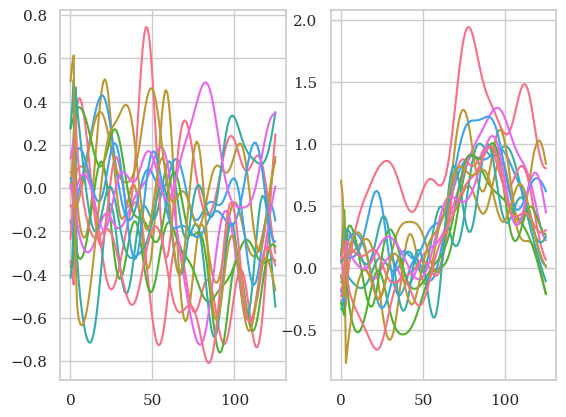

In [ ]:
for inputs, labels in train_dataloader:
    plt.subplot(1,2,1)
    plt.plot(np.mean(inputs.detach().to('cpu').numpy()[labels==0][:,16],axis=0))
    plt.subplot(1,2,2)
    plt.plot(np.mean(inputs.detach().to('cpu').numpy()[labels==1][:,16],axis=0))


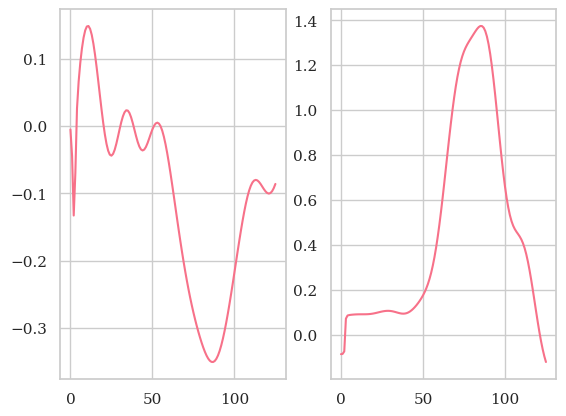

In [ ]:


plt.subplot(1,2,1)
plt.plot(np.mean(Xin[y_train==0][:,16],axis=0))
plt.subplot(1,2,2)
plt.plot(np.mean(Xin[y_train==1][:,16],axis=0))


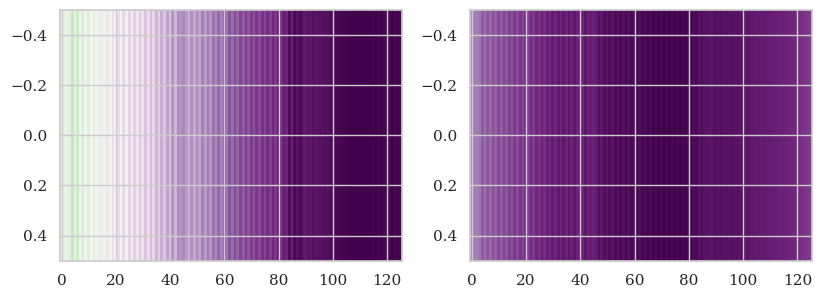

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(4,3,1)
plt.imshow(np.mean(Xwave[y_train==0],axis=0)[:,12,:], cmap='PRGn', aspect='auto',
           vmax=abs(np.mean(Xwave[y_train==0],axis=0))[:,12,:].max(), vmin=-abs(np.mean(Xwave[y_train==0],axis=0))[:,12,:].max(), interpolation='nearest')
plt.subplot(4,3,2)
plt.imshow(np.mean(Xwave[y_train==1],axis=0)[:,12,:], cmap='PRGn', aspect='auto',
           vmax=abs(np.mean(Xwave[y_train==1],axis=0))[:,12,:].max(), vmin=-abs(np.mean(Xwave[y_train==1],axis=0))[:,12,:].max(), interpolation='nearest')

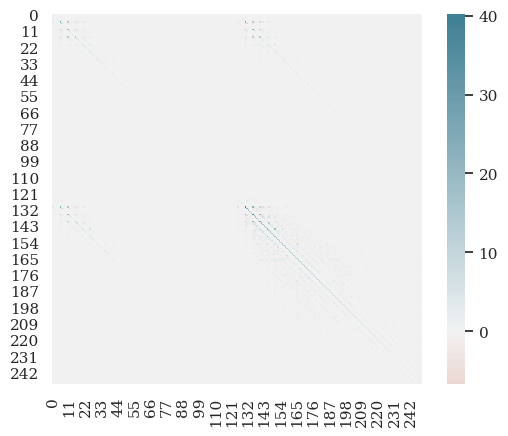

In [ ]:
import seaborn as sns

ax = sns.heatmap(
        np.mean(Xxd[y_train==1],axis=0), center=0, #vmin=-0.05,vmax=0.05,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )

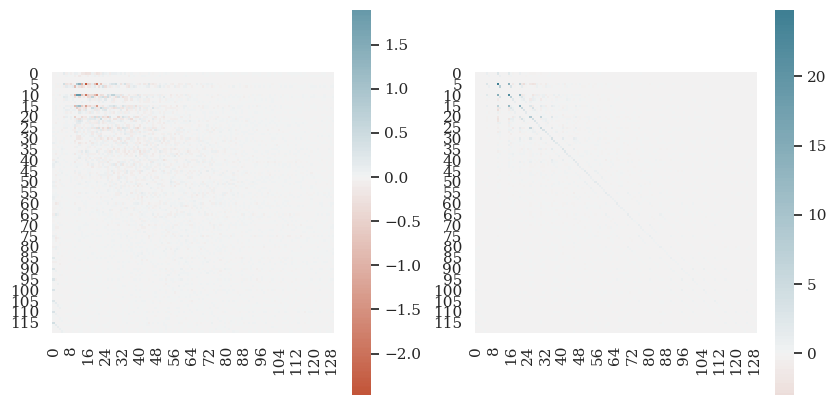

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
ax = sns.heatmap(
        np.mean(Xxd[y_train==0],axis=0)[:120,120:], center=0, #vmin=-0.05,vmax=0.05,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
plt.subplot(1,2,2)
ax = sns.heatmap(
        np.mean(Xxd[y_train==1],axis=0)[:120,120:], center=0, #vmin=-0.05,vmax=0.05,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )

In [63]:
y_pred_norm[:40],y_test_norm[:40]

(array([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

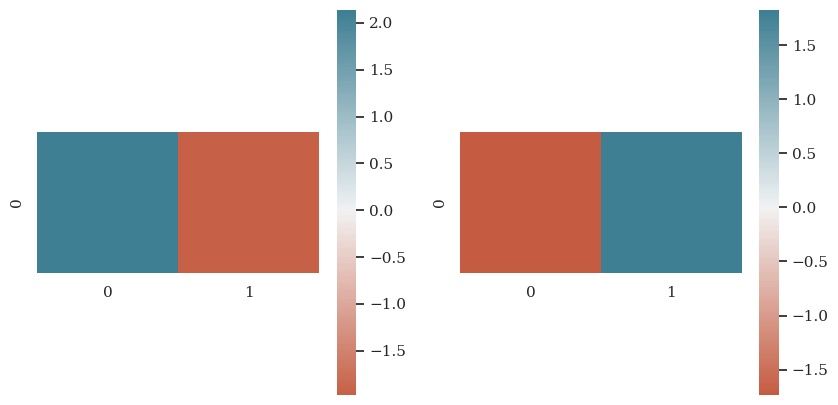

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
ax = sns.heatmap(
        np.mean(np.expand_dims(Xspd[y_train==0],1),axis=0), center=0, #vmin=-0.05,vmax=0.05,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
plt.subplot(1,2,2)
ax = sns.heatmap(
        np.mean(np.expand_dims(Xspd[y_train==1],1),axis=0), center=0, #vmin=-0.05,vmax=0.05,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )

0
0
1
1
1
1
1
0
0
0
0
0
1
0
0
1


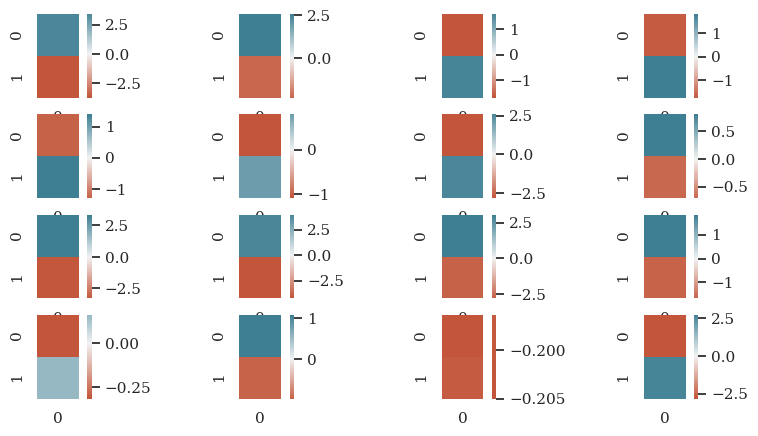

In [65]:
plt.figure(figsize=(10,5))
for i in range(16):
    plt.subplot(4,4,i+1)
    ax = sns.heatmap(
            np.expand_dims(Xspd[i],1), center=0, #vmin=-0.05,vmax=0.05,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True
        )
    print(y_train[i])